# Sonic The Hedgehog 1 with Rainbow

## Step 1: Import the libraries

In [1]:
import time
import retro
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math

%matplotlib inline

In [2]:
import sys
sys.path.append('../../')
from algos.agents.ddqn_agent import DDQNAgent
from algos.models.ddqn_cnn import DDQNCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [3]:
env = retro.make(game='SonicTheHedgehog-Genesis', state='GreenHillZone.Act1', scenario='contest')
env.seed(0)

[0, 592379725]

In [4]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## Step 3: Viewing our Enviroment

The size of frame is:  (224, 320, 3)
No. of Actions:  12


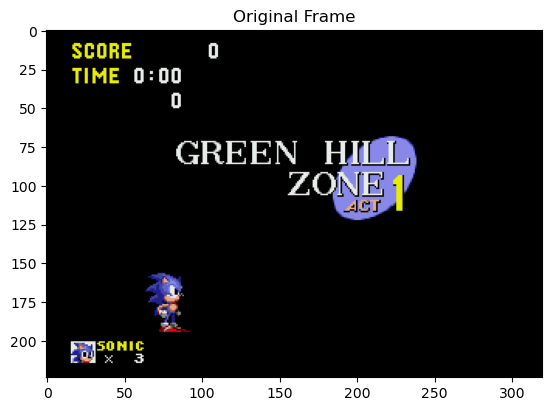

In [5]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

In [6]:
possible_actions = {
            # No Operation
            0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            # Left
            1: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            # Right
            2: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
            # Left, Down
            3: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            # Right, Down
            4: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
            # Down
            5: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            # Down, B
            6: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            # B
            7: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        }

### Execute the code cell below to play Pong with a random policy.

In [7]:
def random_play():
    score = 0
    env.reset()
    for i in range(200):
        env.render()
        action = possible_actions[np.random.randint(len(possible_actions))]
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            print("Your Score at end of game is: ", score)
            break
    env.reset()
    env.render(close=True)
random_play()

## Step 4:Preprocessing Frame

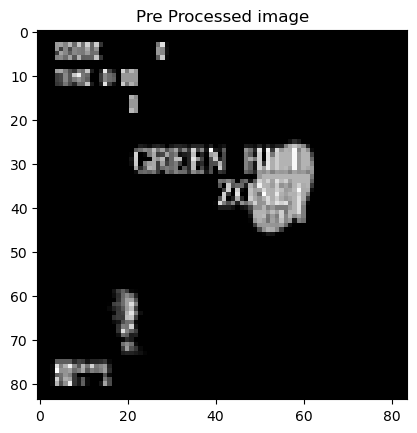

In [8]:
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (1, -1, -1, 1), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [9]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (1, -1, -1, 1), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

## Step 6: Creating our Agent

In [10]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = len(possible_actions)
SEED = 0
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 32        # Update batch size
LR = 0.0001            # learning rate 
TAU = 1e-3             # for soft update of target parameters
UPDATE_EVERY = 100     # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started 
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 100         # Rate by which epsilon to be decayed

agent = DDQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DDQNCnn)

## Step 7: Watching untrained agent play

In [11]:
env.viewer = None
# watch an untrained agent
state = stack_frames(None, env.reset(), True) 
for j in range(200):
    env.render(close=False)
    action = agent.act(state, eps=0.01)
    next_state, reward, done, _ = env.step(possible_actions[action])
    state = stack_frames(state, next_state, False)
    if done:
        env.reset()
        break 
env.render(close=True)

## Step 8: Loading Agent
Uncomment line to load a pretrained agent

In [12]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

## Step 9: Train the Agent with DDQN

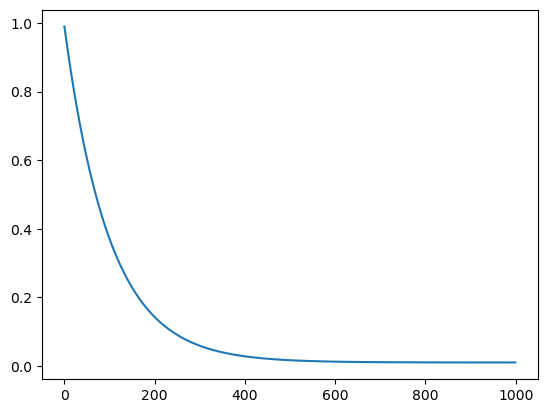

In [13]:
epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

plt.plot([epsilon_by_epsiode(i) for i in range(1000)])

In [14]:
from tqdm import tqdm
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in tqdm(range(start_epoch + 1, n_episodes+1)):
        state = stack_frames(None, env.reset(), True)
        score = 0
        eps = epsilon_by_epsiode(i_episode)

        # Punish the agent for not moving forward
        prev_state = {}
        steps_stuck = 0
        timestamp = 0

        while timestamp < 10000:
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(possible_actions[action])
            score += reward

            timestamp += 1

            # Punish the agent for standing still for too long.
            if (prev_state == info):
                steps_stuck += 1
            else:
                steps_stuck = 0
            prev_state = info
    
            if (steps_stuck > 20):
                reward -= 1
            
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score

        if i_episode % 10 == 0:
            torch.save(agent.policy_net.state_dict(), f'./checkpoints/rainbow/policy_model/checkpoint_dqn_{i_episode}.pth')
            torch.save(agent.target_net.state_dict(), f'./checkpoints/rainbow/target_model/checkpoint_dqn_{i_episode}.pth')
            np.save(f'./checkpoints/rainbow/scores/scores_dqn{i_episode}.npy', np.array(scores))
        
        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(scores_window), eps), end="")
    
    return scores

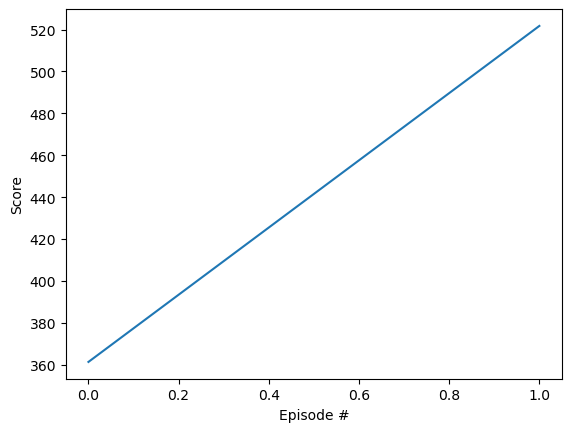

Episode 2	Average Score: 441.56	Epsilon: 0.97

KeyboardInterrupt: 

In [ ]:
scores = train(1000)

## Step 10: Watch a Smart Agent!

In [ ]:
env.viewer = None
# watch an untrained agent
state = stack_frames(None, env.reset(), True) 
for j in range(10000):
    env.render(close=False)
    action = agent.act(state, eps=0.91)
    next_state, reward, done, _ = env.step(possible_actions[action])
    state = stack_frames(state, next_state, False)
    if done:
        env.reset()
        break 
env.render(close=True)